# classificaton terrorist vs counter-terrorist

**The images can be downloaded here:** https://drive.google.com/file/d/16KXaV0iA7eO9nNJKLMcltZb8niDf_LQq/view?usp=sharing

## Prapare variable

In [61]:
# Розмір міні-вибірки
batch_size = 10
# Кількість епох для навчання
epochs = 40
# Розмір зображеннь
img_width, img_height = 150, 150
img_size = (img_width, img_height)
# Кількість каналів в зображенні
img_channels = 3
Image_rgb_size = (img_width, img_height, img_channels)

# Кількість класів зображень
nb_classes = 2
# Назви класів
classes = ['CT', 'T']

# Частина набору даних для тестування
test_data_portion = 0.1
# Частина набору даних для перевірки
val_data_portion = 0.1

# Каталог з набором даних
dataset_dir = '../dataset'

# Каталог з даними для навчання
train_dir = '../train'
# Каталог з даними для перевірки
val_dir = '../val'
# Каталог з даними длятестування
test_dir = '../test'

nb_images = 0
import os
for root, _, files in os.walk(dataset_dir):
    nb_images += len(files)
print(nb_images)

nb_train_samples = nb_images * (1 - test_data_portion - val_data_portion)
nb_test_samples = nb_images * test_data_portion
nb_val_samples = nb_images * val_data_portion
nb_train_samples, nb_val_samples, nb_test_samples

402


(321.6, 40.2, 40.2)

## Prapare data

### Create folder

In [31]:
import shutil, os

def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    [os.makedirs(os.path.join(dir_name, cl)) for cl in classes]

In [32]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

### Find and remove corrupted image

In [33]:
import os
from PIL import Image
count = 0

for root, _, files in os.walk(dataset_dir):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            try:
                img = Image.open(os.path.join(root, filename))
                img.verify()
                img.close()
            except(IOError, SyntaxError)as e:
                print('Bad file to delete :  '+root+"\\"+filename)
                count = count+1
                os.remove(os.path.join(root, filename))
print("Count of corrupted image:", count)

Count of corrupted image: 0


### train \ val \ test split

In [34]:
import shutil
import os
from glob import glob


def copy_images(list_files_to_copy, dest_dir):
    for img in list_files_to_copy:
        shutil.copy2(
            img,
            os.path.join(dest_dir)
        )


def get_list_img_from_dir(from_dir):
    return glob(from_dir+"/*.jpg") + glob(from_dir+"/*.png")


def train_val_test_split(list_images):
    list_train = []
    list_val = []
    list_test = []

    end_train_index = round(
        len(list_images) * (1 - val_data_portion - test_data_portion))
    for i in range(end_train_index):
        list_train.append(list_images[i])

    end_val_index = round(len(list_images) * (1 - test_data_portion))
    for i in range(end_train_index, end_val_index):
        list_val.append(list_images[i])

    for i in range(end_val_index, len(list_images)):
        list_test.append(list_images[i])

    return list_train, list_val, list_test


In [35]:
import random
dirs = [train_dir, val_dir, test_dir]

list_img = get_list_img_from_dir(dataset_dir+"/CT")
random.shuffle(list_img)
for mylist, dir in zip(train_val_test_split(list_img), dirs):
    copy_images(mylist, dir + "\\" + classes[0])

list_img = get_list_img_from_dir(dataset_dir+"/T")
random.shuffle(list_img)
for mylist, dir in zip(train_val_test_split(list_img), dirs):
    copy_images(mylist, dir + "\\" + classes[1])

## Створюємо нейронну мережу

### DataGenerator

In [57]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 322 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


### Create model on InceptionV3

In [47]:
from keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(weights='imagenet',
              include_top=False,
              input_shape=Image_rgb_size)
inception_v3.trainable = False
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

model = Sequential()
model.add(inception_v3)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [49]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [8]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________
None


### Навчаємо нейронну мережу

In [50]:
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data=val_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_val_samples//batch_size)

Epoch 1/50
20/20 [==============================] - 20s 786ms/step - loss: 1.1842 - accuracy: 0.5229 - val_loss: 0.8854 - val_accuracy: 0.5625
Epoch 2/50
20/20 [==============================] - 13s 639ms/step - loss: 1.0127 - accuracy: 0.5915 - val_loss: 0.7393 - val_accuracy: 0.5938
Epoch 3/50
20/20 [==============================] - 13s 641ms/step - loss: 0.8565 - accuracy: 0.6242 - val_loss: 0.6444 - val_accuracy: 0.6562
Epoch 4/50
20/20 [==============================] - 13s 633ms/step - loss: 0.8435 - accuracy: 0.6111 - val_loss: 0.7633 - val_accuracy: 0.5312
Epoch 5/50
20/20 [==============================] - 13s 630ms/step - loss: 0.7756 - accuracy: 0.6176 - val_loss: 0.6659 - val_accuracy: 0.7188
Epoch 6/50
20/20 [==============================] - 14s 707ms/step - loss: 0.7950 - accuracy: 0.6111 - val_loss: 0.5812 - val_accuracy: 0.6875
Epoch 7/50
20/20 [==============================] - 13s 634ms/step - loss: 0.7124 - accuracy: 0.6569 - val_loss: 0.5387 - val_accuracy: 0.6562

## Оцінюємо якість  навчання мережі

In [51]:
# Оцінюємо якість навчання моделі на тестових даних 
scores = model.evaluate(test_generator)
print("Точність роботи на тестових даних: %.2f%%" % (scores[1]*100))

3/3 [==============================] - 2s 509ms/step - loss: 0.3500 - accuracy: 0.8780
Точність роботи на тестових даних: 87.80%


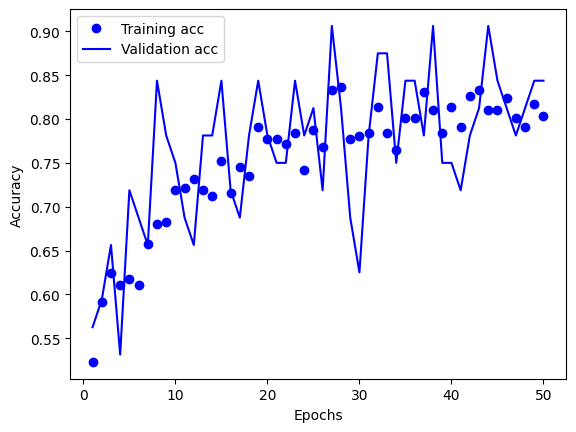

In [52]:
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Зберігаємо навчену нейрону мережу

In [12]:
model.save("ct_vs_t_inception_v3.h5")